In [1]:
import h5py
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torch.nn.utils import clip_grad_norm_
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Resize
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import datasets, transforms
from torch.autograd import Variable
import math
import re
import numpy as np
from scipy.optimize import least_squares
from dask import delayed, compute
from dask.distributed import Client

In [7]:
class LeNet5_inference(nn.Module):
     def __init__(self,num_classes):
        super(LeNet5_inference, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 4, stride = 4))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(144, 48)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(48, 24)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(24, num_classes)
        self.flatten=nn.Flatten()
        

     def forward(self, x):
        x=x.float()
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.flatten(out)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        embedding = self.fc2(out)
        
        return embedding

    


In [8]:
model_pytorch=LeNet5_inference(5)
model_pytorch.load_state_dict(torch.load('../../PytorchLeNet_4848_new.pt'))
model_pytorch.eval() 


LeNet5_inference(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=144, out_features=48, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=48, out_features=24, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=24, out_features=5, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [15]:
path = '/home/ferroelectric/sean/RHEED_4848_test6.h5'

var=np.array([5.46157544e+00, 2.40898228e-01, 9.97084168e+00, 2.41086445e+00, 1.50743760e-03])
mean=np.array([22.47838205, 24.4851125, 16.8462797, 12.07150492, 0.62672398])

with h5py.File(path, 'r') as h5:
    img = h5['growth_6']['spot_2'][0]
    img= img/img.max()
img_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0)
print(img_tensor.shape)
with torch.no_grad():
    output_pytorch = (model_pytorch(img_tensor)).numpy()

output_pytorch = output_pytorch * (var ** 0.5) + (mean)
        
print(output_pytorch)


torch.Size([1, 1, 48, 48])
[[22.97824624 19.38374692  9.89195362  6.17899623  0.48284804]]


In [81]:
import torch
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt

class Gaussian2DDataset(Dataset):
    def __init__(self, size=128, img_dim=1000, testing = False):
        self.size = size
        self.img_dim = img_dim
        self.testing = testing
        self.images = []  # List to store generated images


    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        middle = torch.rand(2) * self.img_dim / 5 + self.img_dim / 2  # random middle pt

        middle=torch.abs(middle)
        cov = torch.randn(2)/2 * 48 / 4 + 48 / 4 + 1e-3  # random covariance
        cov=torch.abs(cov)
        theta = torch.randn(1) * math.pi +1e-6 # random rotation angle
        
        

        x = torch.arange(self.img_dim, dtype=torch.float32).reshape(-1, 1).repeat(1, self.img_dim)
        

        y = torch.arange(self.img_dim, dtype=torch.float32).reshape(1, -1).repeat(self.img_dim, 1)
        

        rota_matrix = torch.tensor([[torch.cos(theta), -torch.sin(theta)],
                                    [torch.sin(theta), torch.cos(theta)]])

        xy = torch.stack([x, y], dim=2)- middle  # shift to mean
       
        xy = torch.einsum('ijk,kl->ijl', xy, rota_matrix)  # rotation


        img = torch.exp(-0.5 * (xy[:, :, 0]**2 / (cov[0]**2+1e-3) + xy[:, :, 1]**2 / (cov[1]**2+1e-3)))


        img = img.unsqueeze(0)

        img = img / img.max()
        
        self.images.append(img)

        bbox = {
        'center_x': middle[1],
        'center_y': middle[0],
        'width': 5 * cov[1],
        'height': 5 * cov[0],
        'theta': theta
        }
        
        # return img_rgb, (middle, cov, theta, bbox)

        return img, bbox




(48, 48)


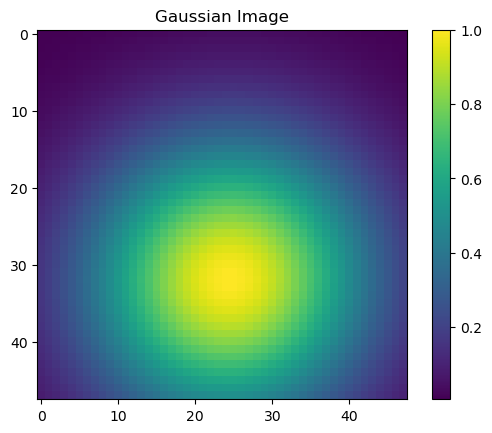

{'center_x': tensor([24.4256]), 'center_y': tensor([31.9960]), 'width': tensor([64.7870]), 'height': tensor([63.3880]), 'theta': tensor([[0.5402]])}


In [85]:
def viz_generator(image):
   
    # Convert image tensor to NumPy array
    image_np = image.numpy()
    fig, ax = plt.subplots()
    #ax.imshow(image_np.transpose(1, 2, 0))
    heatmap = ax.imshow(image_np[0], cmap='viridis')
    cbar = fig.colorbar(heatmap)
    ax.set_title('Gaussian Image')
    print(image_np[0].shape)

    # Show the plot
    plt.show()



# Test the data generator
dataset = Gaussian2DDataset(size=1, img_dim=48)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

for images, bbox in dataloader:
    viz_generator(images[0])
    print(bbox)



[[24.93486748 28.38129492 18.62797651 11.99123318  1.21612407]]
{'center_x': tensor([32.4771]), 'center_y': tensor([26.1829]), 'width': tensor([109.9789]), 'height': tensor([56.4350]), 'theta': tensor([[-0.2075]])}
(48, 48)


/tmp/ipykernel_25548/609030619.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor = torch.tensor(images)


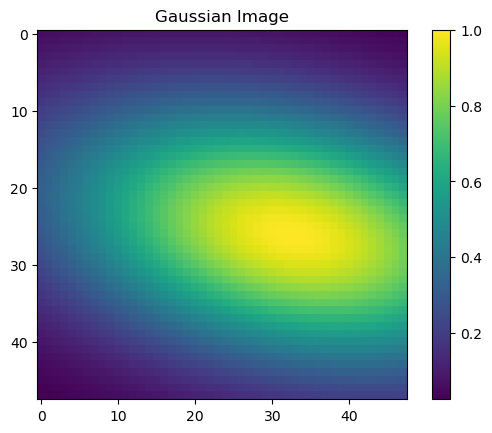

In [90]:

for images, bbox in dataloader:
    img_tensor = torch.tensor(images)
    with torch.no_grad():
        output_pytorch = (model_pytorch(img_tensor)).numpy()

    output_pytorch = output_pytorch * (var ** 0.5) + (mean)
        
    print(output_pytorch)
    print(bbox)
    viz_generator(images[0])
